This tutorial measures the runtime of Global Effect plots, which is mainly influenced by the following factors:

- $t_f$: The runtime of the underlying black-box function, i.e., how much time it takes to apply $f$ on the whole dataset
- $N$: The number of instances.
- $D$: The number of features.
- $T$: The number of points used for centering the feature effect plot.
- $M$: The number of evaluation points

In this tutorial, we'll focus on $t_f$, $N$, and $D$ to measure how each influences the runtime of Global PDP.

In [28]:
import effector
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
np.random.seed(21)

In [29]:
def return_predict(t):
    def predict(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.predict(x)
    return predict

def return_jacobian(t):
    def jacobian(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.jacobian(x)
    return jacobian

In [75]:
def measure_time(method_name, repetitions):
    
    fit_time_list = []
    eval_time_list = []
    for _ in range(repetitions):
        X = np.random.uniform(-1, 1, (N, D))
        xx = np.linspace(-1, 1, M)

        axis_limits = np.zeros((2,D))
        axis_limits[0, :] = -1
        axis_limits[1, :] = 1
        
        if method_name == "pdp":
            pdp = effector.PDP(data=X, model=model, axis_limits=axis_limits)
            
            tic = time.time()
            pdp.fit(0, centering=True, points_for_centering=T, use_vectorized=True)
            fit_time_list.append(time.time()-tic)
            
            tic = time.time()
            pdp.eval(feature=0, xs=xx, centering=True, heterogeneity=True)
            eval_time_list.append(time.time()-tic)
            
        elif method_name == "d_pdp":
            d_pdp = effector.DerPDP(data=X, model=model, model_jac=model_jac, axis_limits=axis_limits)
            
            tic = time.time()
            d_pdp.fit(0, centering=True, points_for_centering=T, use_vectorized=True)
            fit_time_list.append(time.time()-tic)
            
            tic = time.time()
            d_pdp.eval(feature=0, xs=xx, centering=True, heterogeneity=True)
            eval_time_list.append(time.time()-tic)
            
        elif method_name == "ale":
            ale = effector.ALE(data=X, model=model, axis_limits=axis_limits)
    
            tic = time.time()
            ale.fit(0, centering=True, points_for_centering=T)
            fit_time_list.append(time.time()-tic)
            
            tic = time.time()
            ale.eval(feature=0, xs=xx, centering=True, heterogeneity=True)
            eval_time_list.append(time.time()-tic)
        elif method_name == "rhale":
            rhale = effector.RHALE(data=X, model=model, model_jac=model_jac, axis_limits=axis_limits)

            tic = time.time()
            binning_method = effector.binning_methods.Fixed(nof_bins=20)
            rhale.fit(0, centering=True, points_for_centering=T, binning_method=binning_method)
            fit_time_list.append(time.time()-tic)

            tic = time.time()
            rhale.eval(feature=0, xs=xx, centering=True, heterogeneity=True)
            eval_time_list.append(time.time()-tic)
        elif method_name == "shap_dp":
            shap_dp = effector.ShapDP(data=X, model=model, axis_limits=axis_limits)

            tic = time.time()
            shap_dp.fit(0, centering=True, points_for_centering=T)
            fit_time_list.append(time.time()-tic)

            tic = time.time()
            shap_dp.eval(feature=0, xs=xx, centering=True, heterogeneity=True)
            eval_time_list.append(time.time()-tic)

    return {"fit": np.mean(fit_time_list), "eval": np.mean(eval_time_list), "total": np.mean(fit_time_list) + np.mean(eval_time_list)}

## Global effect time (sec) vs $t_f$--time for a single evaluation of f (sec)

In [76]:
t = 0.001
N = 100_000
D = 30
T = 100
M = 100

In [77]:
vec = np.array([.1, .5, 1.]) # , 1., 2.]
time_dict = {"ale": [], "rhale": [], "pdp":[], "d_pdp":[]}
for t in vec:
    print("t:", t)
    model = return_predict(t)
    model_jac = return_jacobian(t)
    time_dict["ale"].append(measure_time("ale", 3))
    time_dict["rhale"].append(measure_time("rhale", 3))
    time_dict["pdp"].app# end(measure_time("pdp", 3))
    time_dict["d_pdp"].append(measure_time("d_pdp", 3))
    # time_dict["shap_dp"].append(measure_time("d_pdp", 3))

t: 0.1


PermutationExplainer explainer: 101it [01:38,  1.03s/it]                                                                                                                               
PermutationExplainer explainer: 101it [01:33,  1.04s/it]                                                                                                                               
PermutationExplainer explainer: 101it [01:33,  1.04s/it]                                                                                                                               


t: 0.5


PermutationExplainer explainer:  41%|██████████████████████████████████████████████▎                                                                  | 41/100 [03:01<04:41,  4.78s/it]


KeyboardInterrupt: 

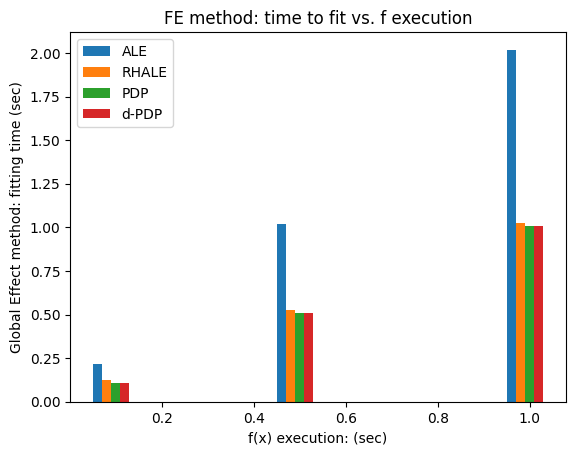

In [66]:
plt.figure()
plt.bar(vec-0.04, [tt["fit"] for tt in time_dict["ale"]], label="ALE", width=0.02)
plt.bar(vec-0.02, [tt["fit"] for tt in time_dict["rhale"]], label="RHALE", width=0.02)
plt.bar(vec, [tt["fit"] for tt in time_dict["pdp"]], label="PDP", width=0.02)
plt.bar(vec+0.02, [tt["fit"] for tt in time_dict["d_pdp"]], label="d-PDP", width=0.02)
plt.title("FE method: time to fit vs. f execution")
plt.xlabel("f(x) execution: (sec)")
plt.ylabel("Global Effect method: fitting time (sec)")
plt.legend()
plt.show()

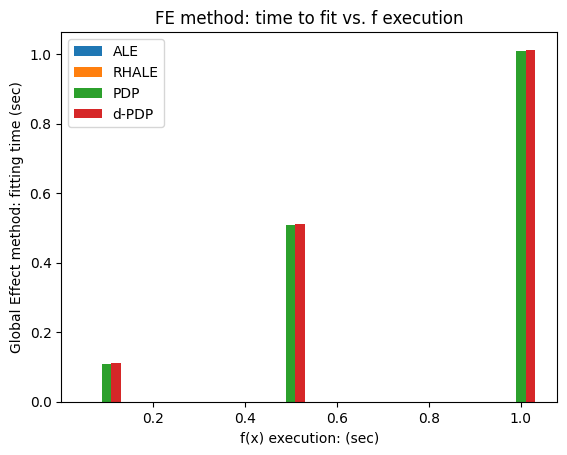

In [70]:
plt.figure()
plt.bar(vec-0.04, [tt["eval"] for tt in time_dict["ale"]], label="ALE", width=0.02)
plt.bar(vec-0.02, [tt["eval"] for tt in time_dict["rhale"]], label="RHALE", width=0.02)
plt.bar(vec, [tt["eval"] for tt in time_dict["pdp"]], label="PDP", width=0.02)
plt.bar(vec+0.02, [tt["eval"] for tt in time_dict["d_pdp"]], label="d-PDP", width=0.02)
plt.title("FE method: time to fit vs. f execution")
plt.xlabel("f(x) execution: (sec)")
plt.ylabel("Global Effect method: fitting time (sec)")
plt.legend()
plt.show()

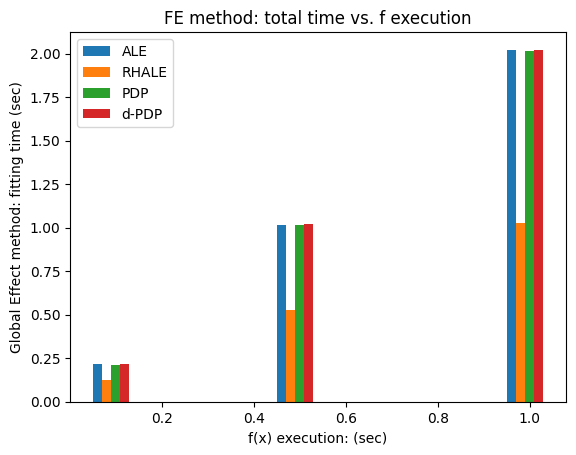

In [71]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(vec-0.04, [tt["total"] for tt in time_dict["ale"]], label="ALE", width=0.02, align='center')
plt.bar(vec-0.02, [tt["total"] for tt in time_dict["rhale"]], label="RHALE", width=0.02, align='center')
plt.bar(vec-0.0, [tt["total"] for tt in time_dict["pdp"]], label="PDP", width=0.02, align='center')
plt.bar(vec+0.02, [tt["total"] for tt in time_dict["d_pdp"]], label="d-PDP", width=0.02, align='center')
plt.title("FE method: total time vs. f execution")
plt.xlabel("f(x) execution: (sec)")
plt.ylabel("Global Effect method: fitting time (sec)")
plt.legend()
plt.show()

## PDP time vs N (nof instances)

In [ ]:
t = 0.001
N = 10_000
D = 10
T = 100

In [ ]:
vec = [1_000, 10_000, 50_000, 100_000, 1_000_000]
time_dict = {"ale": [], "rhale": [], "pdp_vectorized":[]}
for N in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    print("ALE")
    time_dict["ale"].append(measure_time("ale", 3))
    print("RHALE")
    time_dict["rhale"].append(measure_time("rhale", 3))
    print("PDP")
    time_dict["pdp_vectorized"].append(measure_time("pdp_vectorized", 3))

In [ ]:
plt.figure()
plt.plot(vec, time_dict["ale"], "x--", label="ALE")
plt.plot(vec, time_dict["rhale"], "x--", label="RHALE")
plt.plot(vec, time_dict["pdp_vectorized"], "x--", label="pdp (vectorized)")
plt.title("Execution time vs nof instances (N)")
plt.xlabel("number of instances (N)")
plt.ylabel("time (s) for FE execution")
plt.xscale("log")
plt.legend()
plt.show()

## PDP time vs D (nof features)

In [ ]:
t = 0.001
N = 10_000
T = 100

In [ ]:
vec = [5, 10, 50, 100, 200, 300]
time_dict = {"ale": [], "rhale": [], "pdp_vectorized":[]}
for D in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    print("ALE")
    time_dict["ale"].append(measure_time("ale", 3))
    print("RHALE")
    time_dict["rhale"].append(measure_time("rhale", 3))
    print("PDP")
    time_dict["pdp_vectorized"].append(measure_time("pdp_vectorized", 3))

In [ ]:
plt.figure()
plt.plot(vec, time_dict["ale"], "x--", label="ALE")
plt.plot(vec, time_dict["rhale"], "x--", label="RHALE")
plt.plot(vec, time_dict["pdp_vectorized"], "x--", label="pdp (vectorized)")
plt.title("Execution time vs nof features (D)")
plt.xlabel("number of features (D)")
plt.ylabel("time (s) for FE execution")
# plt.xscale("log")
plt.legend()
plt.show()

## Conclusion

In practice, the vectorized version outperforms the non-vectorized version in all cases:

- The runtime of the black-box model is the key factor. As the model size increases, the non-vectorized implementation shows a linear increase in runtime, while the vectorized implementation remains unaffected.
- The number of instances does not significantly impact the runtime for either version, as long as \( y \) can be obtained in a single pass of \( f(x) \).
- Both versions scale linearly with the number of features, but the vectorized version is consistently faster by a constant margin.